<a href="https://colab.research.google.com/github/Ahmedfull02/MICROSOFT-SECURITY-INCIDENT-PREDICTION-USING-MULTI-AGENT-SYSTEM/blob/master/Practica_SIGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Download necessary files

## 0.1 Downloading Dataset

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
microsoft_microsoft_security_incident_prediction_path = kagglehub.dataset_download('Microsoft/microsoft-security-incident-prediction')
# if microsoft_microsoft_security_incident_prediction_path == '/kaggle/input/microsoft-security-incident-prediction':
print('Data source import complete.')
# else :
#   print('Data source import failed.will retry one more time')
#   microsoft_microsoft_security_incident_prediction_path = kagglehub.dataset_download('Microsoft/microsoft-security-incident-prediction')

Data source import complete.


## 0.2 Downloading libraries

In [2]:
# !pip install pandas matplotlib seaborn numpy scikit-learn catboost

In [3]:
# !pip install imbalanced-learn

# MICROSOFT SECURITY INCIDENT PREDICTION USING MULTI AGENT SYSTEM


# 1. Environment Setup

## 1.1. Imports

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 1.2. Plot Styling

In [5]:
def style_and_save(
    ax,
    title='',
    xlabel='',
    ylabel='',
    filename='plot.png',
    title_pad=20,
    xlabel_pad=15,
    ylabel_pad=15,
    xtick_rotation=0,
    ytick_rotation=0,
    grid_axis='y',
    fontsize=11,
    show_legend=True
):
    ax.set_title(title, fontsize=12, fontweight='bold', pad=title_pad)
    ax.set_xlabel(xlabel, fontsize=10, fontweight='semibold', labelpad=xlabel_pad)
    ax.set_ylabel(ylabel, fontsize=10, fontweight='semibold', labelpad=ylabel_pad)
    ax.tick_params(axis='x', labelrotation=xtick_rotation, labelsize=fontsize)
    ax.tick_params(axis='y', labelrotation=ytick_rotation, labelsize=fontsize)
    ax.grid(axis=grid_axis, linestyle='--', alpha=0.5)
    if show_legend:
        ax.legend(loc='lower right', fontsize=10)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

In [6]:
def create_count_plot(
    df,
    column,
    title='',
    xlabel='',
    ylabel='',
    filename='count_plot.png',
    order=None,
    xtick_rotation=0,
    annotate_values=False,
    figsize=(8, 5)
):
    plt.figure(figsize=figsize)
    ax = sns.countplot(
        data=df[df[column].notnull()],
        x=column,
        order=order,
        edgecolor='gray',
        palette='pastel'
    )

    if annotate_values:
        for bar in ax.patches:
            height = bar.get_height()
            ax.annotate(f'{height:,}',
                        (bar.get_x() + bar.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10, fontweight='semibold')

    style_and_save(
        ax,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        filename=filename,
        xtick_rotation=xtick_rotation
    )


In [7]:
def create_stacked_barh(
    df,
    title='',
    xlabel='',
    ylabel='',
    filename='stacked_barh.png',
    colors=None,
    figsize=(10, 6),
    annotate_values=False
):
    if colors is None:
        colors = sns.color_palette('pastel')[:df.shape[1]]

    ax = df.plot(
        kind='barh',
        stacked=True,
        figsize=figsize,
        color=colors,
        edgecolor='gray'
    )

    if annotate_values:
        for container in ax.containers:
            for bar in container:
                width = bar.get_width()
                if width > 0:
                    ax.text(
                        bar.get_x() + width / 2,
                        bar.get_y() + bar.get_height() / 2,
                        f'{int(width):,}',
                        ha='center', va='center',
                        fontsize=9
                    )

    style_and_save(
        ax,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        filename=filename,
        grid_axis='x'
    )

## 1.3. Dataset Loading

In [8]:
# DO NOT IMPORT DATASET WITH THIS LINE IF YOU HAVE LIMITED RAM IN COLAB
#df = pd.read_csv('/kaggle/input/microsoft-security-incident-prediction/GUIDE_Train.csv')

In [9]:
# RUN THIS INSTEAD
chunks = pd.read_csv('/kaggle/input/microsoft-security-incident-prediction/GUIDE_Train.csv',chunksize=5000)
df = pd.concat(chunks)

## 2. Exploratory Data Analysis

### 2.1. Dataset Definition

#### 2.1.1. Columns

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailClusterId      floa

## 2.1.1. Variables (Columns)

| Feature               | Description |
|-----------------------|------------|
| Id                    | Unique identifier for each OrgId-IncidentId combination, ensuring global uniqueness of each record |
| OrgId                 | Identifier for the organization where the incident or alert originated (used to separate data across tenants) |
| IncidentId            | Unique identifier assigned by the organization to each tracked security incident |
| AlertId               | Unique identifier for an individual alert generated by a detection system |
| Timestamp             | Date and time when the alert was created (UTC format) |
| DetectorId            | Identifier of the detection engine that generated the alert |
| AlertTitle            | Descriptive title summarizing the nature of the alert |
| Category              | Broad classification of the alert (type of detected threat) |
| MitreTechniques       | List of MITRE ATT&CK techniques associated with the alert |
| IncidentGrade         | Severity level assigned by the Security Operations Center |
| ActionGrouped         | High-level description of the remediation action taken |
| ActionGranular        | Detailed description of the specific remediation measures |
| EntityType            | Type of entity involved in the alert |
| EvidenceRole          | Role of the evidence within the investigation |
| Roles                 | Additional metadata labels for entity roles in the alert |
| DeviceId              | Unique identifier for the device involved |
| DeviceName            | Human-readable name of the device involved |
| Sha256                | SHA-256 hash of the file involved |
| IpAddress             | IP address associated with the alert |
| Url                   | URL involved in the alert |
| AccountSid            | Identifier for an on-premises account linked to the alert |
| AccountUpn            | User Principal Name of the account involved |
| AccountObjectId       | Entra ID object identifier for the user/account |
| AccountName           | Username of the on-premises account involved |
| NetworkMessageId      | Organization-level unique identifier for email messages |
| EmailClusterId        | Identifier for a cluster of related email messages |
| RegistryKey           | Windows registry key involved |
| RegistryValueName     | Name of the registry value that was modified/accessed |
| RegistryValueData     | Data stored in the registry value at alert time |
| ApplicationId         | Unique identifier for an application involved |
| ApplicationName       | Name of the application involved |
| OAuthApplicationId    | Identifier for the OAuth application involved |
| ThreatFamily          | Name of the detected malware family |
| FileName              | Name of the file involved |
| FolderPath            | Path where the file was located at alert time |
| ResourceIdName        | Name of the Azure resource involved |
| ResourceType          | Type of Azure resource involved |
| OSFamily              | Operating system family of the device |
| OSVersion             | Operating system version of the device |
| AntispamDirection     | Direction of email traffic processed by antispam |
| SuspicionLevel        | Assigned level of suspicion for the alert/entity |
| LastVerdict           | Final classification after review |
| CountryCode           | ISO country code of the alert's geographic location |
| State                 | State/province name of the alert evidence location |
| City                  | City name of the alert evidence location |

### 2.1.2. Entries

In [11]:
total_rows = len(df)
print(f"{total_rows:,}")

9,516,837


## 2.2. Target Variable Selection

In [12]:
candidates_var = ['IncidentGrade', 'SuspicionLevel', 'LastVerdict', 'Category']

for col in candidates_var:
    print(f"\n📌 Variable: {col}")
    print("-" * 40)
    print(f"Unique values:\n{df[col].unique()}")
    print(f"\nnumber of NULL values: {df[col].isnull().sum()} de {len(df)} registros totales")
    print("=" * 60)


📌 Variable: IncidentGrade
----------------------------------------
Unique values:
['TruePositive' 'FalsePositive' 'BenignPositive' nan]

number of NULL values: 51340 de 9516837 registros totales

📌 Variable: SuspicionLevel
----------------------------------------
Unique values:
[nan 'Suspicious' 'Incriminated']

number of NULL values: 8072708 de 9516837 registros totales

📌 Variable: LastVerdict
----------------------------------------
Unique values:
[nan 'Suspicious' 'Malicious' 'NoThreatsFound'
 'DomainPII_50d8b4a941c26b89482c94ab324b5a274f9ced66'
 'DomainPII_9207384283ce115db5a590dd9ca5de21e5e99df2']

number of NULL values: 7282572 de 9516837 registros totales

📌 Variable: Category
----------------------------------------
Unique values:
['InitialAccess' 'Exfiltration' 'CommandAndControl' 'Execution'
 'SuspiciousActivity' 'Impact' 'Collection' 'CredentialAccess'
 'Persistence' 'Discovery' 'Malware' 'DefenseEvasion' 'Exploit'
 'PrivilegeEscalation' 'LateralMovement' 'Ransomware' 'Unw

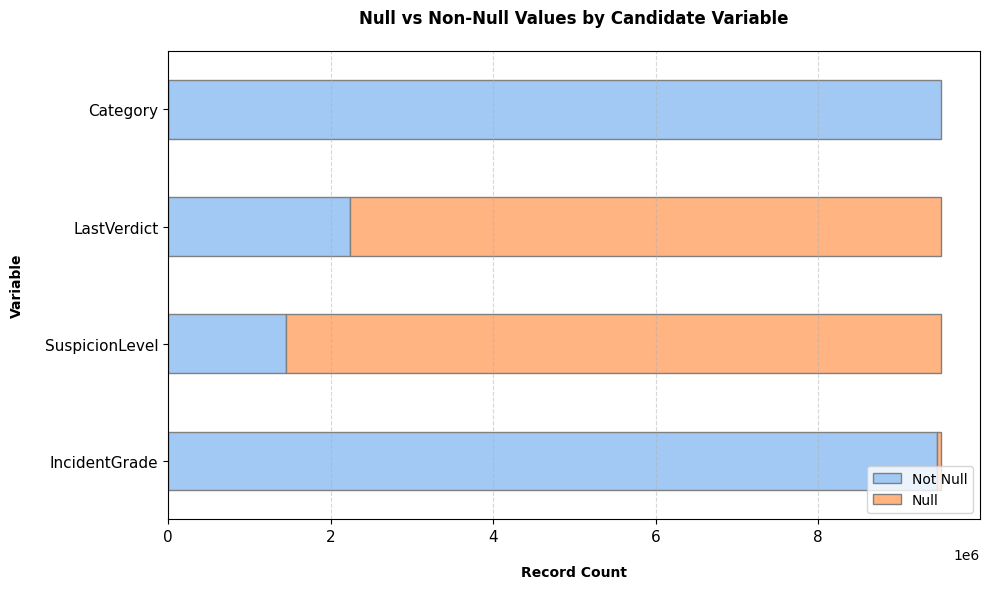

In [13]:
vars = ['IncidentGrade', 'SuspicionLevel', 'LastVerdict', 'Category']

# Calculation of null and non-null values

data = {
    'Not Null': [df[var].notnull().sum() for var in vars],
    'Null': [df[var].isnull().sum() for var in vars]
}

# DataFrame creation

df_nulls = pd.DataFrame(data, index=vars)

# Plot

create_stacked_barh(
    df=df_nulls,
    title='Null vs Non-Null Values by Candidate Variable',
    xlabel='Record Count',
    ylabel='Variable',
    filename='null_values_by_variable.png',
    annotate_values=False
)


## 2.3. Target Variable Distribution

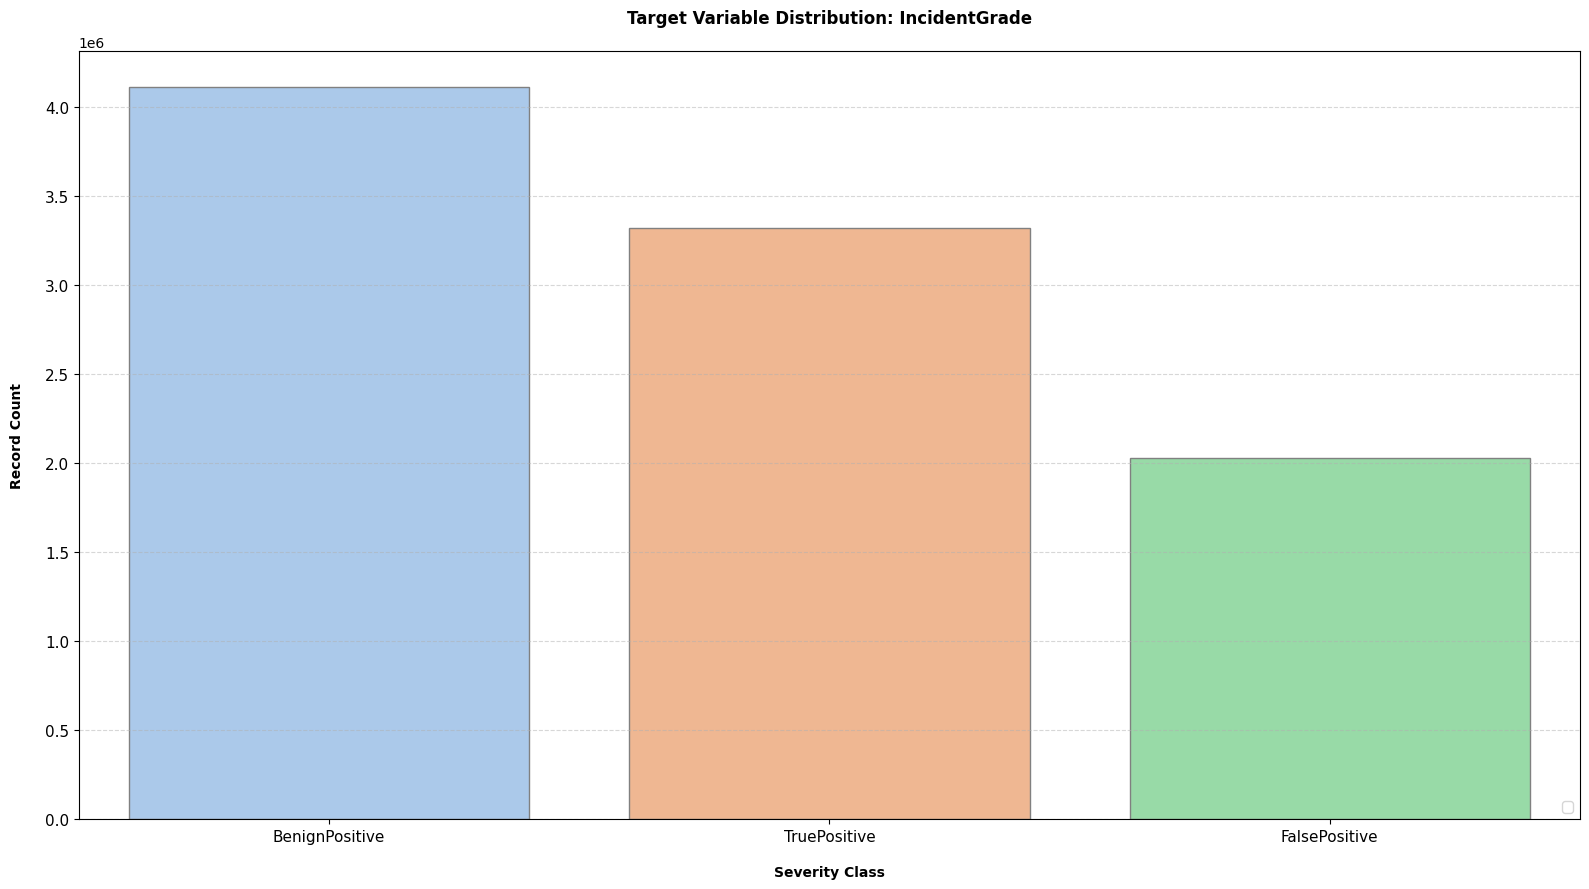

In [14]:
create_count_plot(
    df=df,
    column='IncidentGrade',
    title='Target Variable Distribution: IncidentGrade',
    xlabel='Severity Class',
    ylabel='Record Count',
    filename='target_variable_distribution.png',
    order=df['IncidentGrade'].value_counts().index,
    figsize=(16,9)
)

## 2.4. Missing Values Visualization

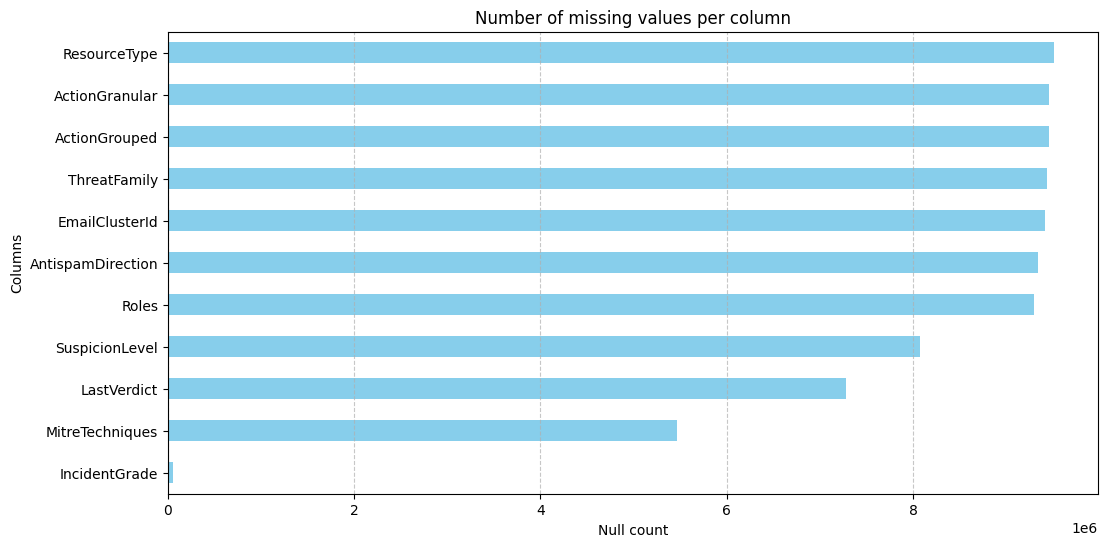

In [15]:
# Count null values per column

missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values()

# Visualize

plt.figure(figsize=(12, 6))
missing_values.plot(kind='barh', color='skyblue')
plt.title('Number of missing values per column')
plt.xlabel('Null count')
plt.ylabel('Columns')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 3. Preprocessing

## 3.1. Data Cleaning

### 3.1.1. Dropping Rows/Columns with Null Values

In [16]:
def viewRemainingColumns():
    numeric_columns = df.select_dtypes(include=['float64', 'int64', 'int32']).columns
    string_columns = df.select_dtypes(include=['object']).columns

    # Print column names
    print("Numeric columns:")
    print(numeric_columns)
    print(f"Total of Numeric columns: {len(numeric_columns)}\n")

    print("String columns:")
    print(string_columns)
    print(f"Total of String columns: {len(string_columns)}")

In [17]:
# Drop columns with more than 70% null values

columns_with_high_null = []

for column in df.columns:
    if df[column].isnull().sum() / total_rows > 0.7:
        columns_with_high_null.append(column)

print("Columns with >70% null values:", columns_with_high_null)
print(f"Total columns to drop: {len(columns_with_high_null)}\n")

df = df.drop(columns=columns_with_high_null)

Columns with >70% null values: ['ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']
Total columns to drop: 9



In [18]:
viewRemainingColumns()

Numeric columns:
Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City'],
      dtype='object')
Total of Numeric columns: 30

String columns:
Index(['Timestamp', 'Category', 'MitreTechniques', 'IncidentGrade',
       'EntityType', 'EvidenceRole'],
      dtype='object')
Total of String columns: 6


In [19]:
# Drop rows with null IncidentGrade to avoid fabricating target class values

df = df.dropna(subset=['IncidentGrade'])

total_rows_after_delete = len(df)
print(f"{round((total_rows_after_delete / total_rows * 100), 2)}%")

99.46%


In [20]:
# Update total row count after cleaning
total_rows = total_rows_after_delete
print(f"Updated dataset contains {total_rows:,} records")

Updated dataset contains 9,465,497 records


### 3.1.2. Null value Removing

In [21]:
# Remove missing MitreTechniques values with the mode (most frequent value)

print(df['MitreTechniques'].isnull().sum())

mode = df['MitreTechniques'].mode()[0]

df.fillna({'MitreTechniques': mode}, inplace=True)

print(df['MitreTechniques'].isnull().sum())

5427513
0


### 3.1.3. Remove irrelevant columns

In [22]:
def format_percentage(num_uniques, total_rows):
    percentage = (num_uniques / total_rows) * 100
    rounded = round(percentage, 2)
    return "<0.01%" if rounded == 0.0 and num_uniques > 0 else f"{rounded:.2f}%"

In [23]:
def get_uniques_list(cols):
    return sorted(
        [(col, df[col].nunique()) for col in cols],
        key=lambda x: x[1],
        reverse=True)


In [24]:
# Check uniqueness of ID records

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
string_cols = df.select_dtypes(include=['object']).columns

numeric_uniques = get_uniques_list(numeric_cols)
string_uniques = get_uniques_list(string_cols)

print("\nUnique values for each numeric column:\n")
print(f"{'Column':<30} {'Unique':<10} {'% of total'}")
print("-" * 55)
for col, num_uniques in numeric_uniques:
    percentage_str = format_percentage(num_uniques, total_rows)
    print(f"{col:<30} {num_uniques:<10} {percentage_str}")

print("\n\nUnique values for each categorical column:\n")
print(f"{'Column':<30} {'Unique':<10} {'% of total'}")
print("-" * 55)
for col, num_uniques in string_uniques:
    percentage_str = format_percentage(num_uniques, total_rows)
    print(f"{col:<30} {num_uniques:<10} {percentage_str}")



Unique values for each numeric column:

Column                         Unique     % of total
-------------------------------------------------------
AlertId                        1248789    13.19%
Id                             707108     7.47%
AccountUpn                     524760     5.54%
IncidentId                     448901     4.74%
NetworkMessageId               375196     3.96%
AccountName                    363254     3.84%
AccountSid                     353113     3.73%
AccountObjectId                338252     3.57%
IpAddress                      285957     3.02%
FileName                       222085     2.35%
Url                            123252     1.30%
DeviceName                     114267     1.21%
Sha256                         106416     1.12%
FolderPath                     87832      0.93%
AlertTitle                     79952      0.84%
DeviceId                       75557      0.80%
City                           9342       0.10%
DetectorId                     78

In [25]:
# List of irrelevant columns for the correlation matrix
# Selection based on previous output (>3%)
irrelevant_columns = ['AlertId', 'Id', 'AccountUpn', 'IncidentId', 'NetworkMessageId',
                     'AccountName', 'AccountSid', 'AccountObjectId', 'IpAddress']

df = df.drop(columns=irrelevant_columns)

viewRemainingColumns()

Numeric columns:
Index(['OrgId', 'DetectorId', 'AlertTitle', 'DeviceId', 'Sha256', 'Url',
       'DeviceName', 'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City'],
      dtype='object')
Total of Numeric columns: 21

String columns:
Index(['Timestamp', 'Category', 'MitreTechniques', 'IncidentGrade',
       'EntityType', 'EvidenceRole'],
      dtype='object')
Total of String columns: 6


## 3.2. Encoding of categorical variables

In [26]:
from sklearn.preprocessing import LabelEncoder

# Select object-type columns excluding 'Timestamp'
encode_label = df.select_dtypes([object]).columns
encode_label = [col for col in encode_label if col != 'Timestamp']

print(encode_label)

# Dictionary to store fitted encoders
label_encoders = {}

# Apply LabelEncoder to each categorical column (excluding 'Timestamp')
for col in encode_label:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


['Category', 'MitreTechniques', 'IncidentGrade', 'EntityType', 'EvidenceRole']


### 3.3. Date/Time Processing

#### 3.3.1. DateTime Conversion

In [27]:
### 3.3.2. Date Aggregation

unique_lengths = set(df['Timestamp'].map(len))
print(unique_lengths)

df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Second'] = df['Timestamp'].dt.second
df['Weekday'] = df['Timestamp'].dt.weekday  # 0 = Monday, 6 = Sunday

{24}


### 3.3.2. Date Aggregation

In [28]:
## Day: 0 | Night: 1

def asign_period(hour):
    if 7 <= hour < 19:
        return 0
    else:
        return 1


## Spring: 0 | Summer: 1 | Autumn: 2 | Winter: 3

def asign_season(month):
    if 3 <= month <= 5:
        return 0
    elif 6 <= month <= 8:
        return 1
    elif 9 <= month <= 11:
        return 2
    else:
        return 3


## holidays Period: 0 | Non holidays Period: 1

def asign_holidays(weekday):
    if 0 <= weekday < 5:
        return 0
    else:
        return 1

In [29]:
# for time slot
df['Period'] = df['Hour'].apply(asign_period)

# For season
df['Season'] = df['Month'].apply(asign_season)

# For Holiday
df['Holiday'] = df['Weekday'].apply(asign_holidays)

In [30]:
viewRemainingColumns()

Numeric columns:
Index(['OrgId', 'DetectorId', 'AlertTitle', 'Category', 'MitreTechniques',
       'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId', 'Sha256',
       'Url', 'DeviceName', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName',
       'OSFamily', 'OSVersion', 'CountryCode', 'State', 'City', 'Year',
       'Month', 'Day', 'Hour', 'Minute', 'Second', 'Weekday', 'Period',
       'Season', 'Holiday'],
      dtype='object')
Total of Numeric columns: 36

String columns:
Index([], dtype='object')
Total of String columns: 0


### 3.3.3. Removal of Date Attributes

In [31]:
print("Unique values for the year:", len(df['Year'].unique()))  # This variable can be removed

Unique values for the year: 2


In [32]:
df = df.drop(columns=['Year', 'Month', 'Weekday', 'Day', 'Hour', 'Minute', 'Second'])
df = df.drop(columns=['Timestamp'])

In [33]:
viewRemainingColumns()

Numeric columns:
Index(['OrgId', 'DetectorId', 'AlertTitle', 'Category', 'MitreTechniques',
       'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId', 'Sha256',
       'Url', 'DeviceName', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName',
       'OSFamily', 'OSVersion', 'CountryCode', 'State', 'City', 'Period',
       'Season', 'Holiday'],
      dtype='object')
Total of Numeric columns: 29

String columns:
Index([], dtype='object')
Total of String columns: 0


## 3.4. Correlation Analysis

### 3.4.1. Correlation Matrix

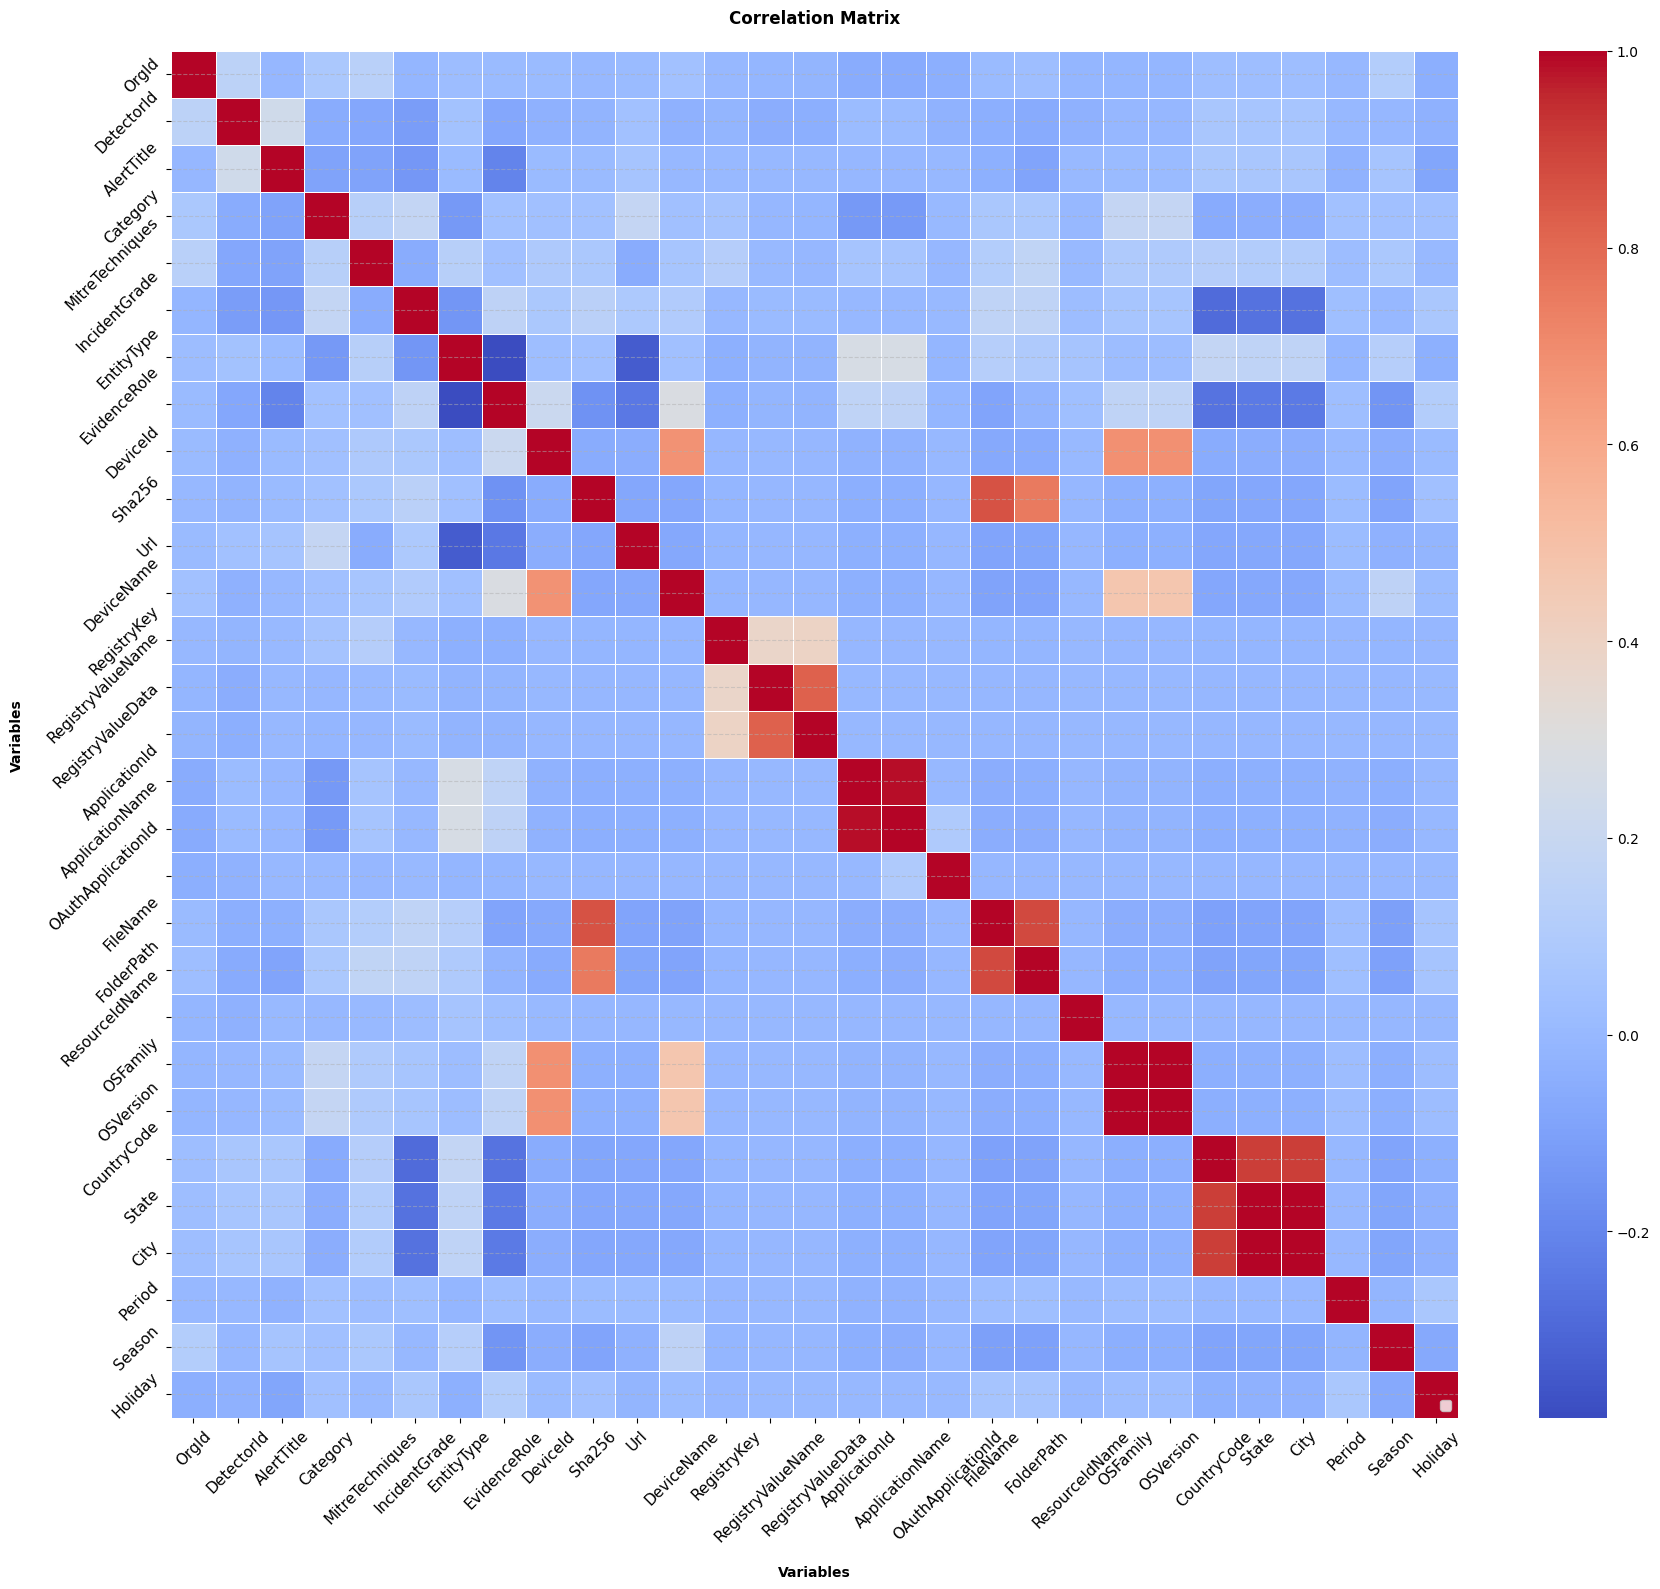

In [34]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(18, 16))
ax = sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")

style_and_save(
    ax=ax,
    title='Correlation Matrix',
    xlabel='Variables',
    ylabel='Variables',
    filename='Correlation Matrix.png',
    xtick_rotation=45,
    ytick_rotation=45
)

### 3.4.2. Elimination of highly correlated variables

In [35]:
threshold = 0.7

abs_corr = correlation_matrix.abs()
high_corr_pairs = []

num_cols = abs_corr.shape[1]

for i in range(num_cols):
    for j in range(i + 1, num_cols):
        corr_value = abs_corr.iloc[i, j]
        if corr_value > threshold:
            high_corr_pairs.append((abs_corr.columns[i], abs_corr.columns[j], corr_value))

if high_corr_pairs:
    print(f"Pairs of variables with correlation greater than {threshold}:")
    print(f"{'Variable 1':<20} {'Variable 2':<20} {'Correlation'}")
    print("-" * 55)
    for col1, col2, corr_value in high_corr_pairs:
        print(f"{col1:<20} {col2:<20} {corr_value:.2f}")
else:
    print(f"There are no pairs with correlation greater than {threshold}")

Pairs of variables with correlation greater than 0.7:
Variable 1           Variable 2           Correlation
-------------------------------------------------------
Sha256               FileName             0.86
Sha256               FolderPath           0.75
RegistryValueName    RegistryValueData    0.82
ApplicationId        ApplicationName      0.99
FileName             FolderPath           0.88
OSFamily             OSVersion            1.00
CountryCode          State                0.91
CountryCode          City                 0.91
State                City                 1.00


In [36]:
df = df.drop(columns=['Sha256', 'FileName', 'RegistryValueData', 'ApplicationName', 'OSVersion', 'City', 'State'])

In [37]:
viewRemainingColumns()

Numeric columns:
Index(['OrgId', 'DetectorId', 'AlertTitle', 'Category', 'MitreTechniques',
       'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId', 'Url',
       'DeviceName', 'RegistryKey', 'RegistryValueName', 'ApplicationId',
       'OAuthApplicationId', 'FolderPath', 'ResourceIdName', 'OSFamily',
       'CountryCode', 'Period', 'Season', 'Holiday'],
      dtype='object')
Total of Numeric columns: 22

String columns:
Index([], dtype='object')
Total of String columns: 0


## 3.5. Manual filter

In [38]:
df = df.drop(columns=['OrgId', 'DetectorId', 'DeviceId', 'ApplicationId', 'OAuthApplicationId'])

In [39]:
viewRemainingColumns()

Numeric columns:
Index(['AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'EntityType', 'EvidenceRole', 'Url', 'DeviceName', 'RegistryKey',
       'RegistryValueName', 'FolderPath', 'ResourceIdName', 'OSFamily',
       'CountryCode', 'Period', 'Season', 'Holiday'],
      dtype='object')
Total of Numeric columns: 17

String columns:
Index([], dtype='object')
Total of String columns: 0


## 3.6. Anomaly Detection
### 3.5.1. Remove Outliers
### 3.5.2. PCA

# 4. Training

## 4.1. Training Preparation

### 4.1.1. Imports

In [40]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### 4.1.2. Encoding of the Target Variable

In [41]:
label_map = {
    'BenignPositive': 0,
    'FalsePositive': 1,
    'TruePositive': 2
}

### 4.1.3. Data Splitting

In [42]:
# X e y
X = df.drop(columns=['IncidentGrade'])
y = df['IncidentGrade']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=42, stratify=y
)

## 4.2. Modeling

### 4.2.1 Non Balanced dataset

In [44]:
# models = {
#     'CatBoost': CatBoostClassifier(verbose=True),
#     'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=2),
#     'RandomForest': RandomForestClassifier(verbose=2)
# }

## 4.3. Training

In [45]:
# for name, model in models.items():
#    print(f"\Training {name}...")
#    model.fit(X_train, y_train)
#    print("Testing...") 
#    y_pred = model.predict(X_test)
#    print(f"\n{name} Classification Report:")
#    print(classification_report(y_test, y_pred))

## 4.4 Save Models as file

In [46]:
# import joblib
# import os
# # Output directory
# output_dir = 'trained_models'
# os.makedirs(output_dir, exist_ok=True)
# # 
# # Save each model
# for name, model in models.items():
#     filename = os.path.join(output_dir, f'{name}_model.joblib')
#     joblib.dump(model, filename)
#     print(f"Model '{name}' saved to '{filename}'")


## 4.5 Load models (Optional)

In [47]:
# loaded_models = {}
# for name in models.keys(): # Use the original key names for consistency
#     filename = os.path.join(output_dir, f'{name}_model.joblib')
#     if os.path.exists(filename):
#         loaded_model = joblib.load(filename)
#         loaded_models[name] = loaded_model
#         print(f"Model '{name}' loaded from '{filename}'")
#     else:
#         print(f"File '{filename}' not found for model '{name}'.")

# for name, model in loaded_models.items():
#    print("Testing...") 
#    y_pred = model.predict(X_test)
#    print(f"\n{name} Classification Report:")
#    print(classification_report(y_test, y_pred))

### 4.2.2 Balanced dataset

In [48]:
models_balanced = {
    'CatBoost': CatBoostClassifier(auto_class_weights='Balanced', verbose=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=2), # XGBoost does not have an argument to apply weighted class
    'RandomForest': RandomForestClassifier(class_weight='balanced', verbose=2)
}

In [49]:
# Calculate class weight manually for XGBoost
from sklearn.utils.class_weight import compute_class_weight


# Get Classes
classes = np.unique(y_test)

class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# For XGBoost: Convert class weights to sample weights
sample_weights = y_train.map(class_weight_dict)

## 4.3. Training

In [50]:
for name, model in models_balanced.items():
    print(f"\Training {name}...")
    if name == 'XGBoost':
        model.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        model.fit(X_train, y_train)
    print("Testing...") 
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

\Training CatBoost...
Learning rate set to 0.124786
0:	learn: 1.0516423	total: 2.61s	remaining: 43m 27s
1:	learn: 1.0165454	total: 5.18s	remaining: 43m 5s
2:	learn: 0.9895958	total: 7.64s	remaining: 42m 20s
3:	learn: 0.9684479	total: 9.88s	remaining: 40m 59s


KeyboardInterrupt: 

## 4.4 Save Models as file

In [ ]:
import joblib
import os
# Output directory
output_dir = 'trained_models_balanced'
os.makedirs(output_dir, exist_ok=True)

# Save each model
for name, model in models_balanced.items():
    filename = os.path.join(output_dir, f'{name}_model.joblib')
    joblib.dump(model, filename)
    print(f"Model '{name}' saved to '{filename}'")


## 4.5 Load models (Optional)

In [ ]:
loaded_models_balanced = {}
for name in models_balanced.keys(): # Use the original key names for consistency
    filename = os.path.join(output_dir, f'{name}_model.joblib')
    if os.path.exists(filename):
        loaded_model = joblib.load(filename)
        loaded_models_balanced[name] = loaded_model
        print(f"Model '{name}' loaded from '{filename}'")
    else:
        print(f"File '{filename}' not found for model '{name}'.")

for name, model in loaded_models_balanced.items():
   print("Testing...") 
   y_pred = model.predict(X_test)
   print(f"\n{name} Classification Report:")
   print(classification_report(y_test, y_pred))

## 4.4. Class Balancing

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import CondensedNearestNeighbour
# from sklearn.utils import shuffle
# from sklearn.cluster import KMeans
# from sklearn.metrics import pairwise_distances_argmin_min
# from imblearn.under_sampling import ClusterCentroids
# from sklearn.cluster import MiniBatchKMeans
# from sklearn.utils import resample
# import time

In [ ]:
# target_size = y.value_counts()[1]

In [ ]:
# # 1. Undersample clase 0 (BenignPositive)
# rus_0 = RandomUnderSampler(sampling_strategy={0: target_size}, random_state=42)
# X_rus_0, y_rus_0 = rus_0.fit_resample(X, y)

In [ ]:
# 2. Oversample clase 1 (FalsePositive) based on the result of the previous step
# smote = SMOTE(sampling_strategy={1: target_size}, random_state=42)
# X_balanced, y_balanced = smote.fit_resample(X_rus, y_rus)

In [ ]:
# # 2. Undersample clase 2 (BenignPositive)
# rus_2 = RandomUnderSampler(sampling_strategy={2: target_size}, random_state=42)
# X_rus_final, y_rus_final = rus_2.fit_resample(X_rus_0, y_rus_0)

In [ ]:
# # 3.  Shuffle Data
# X_balanced, y_balanced = shuffle(X_rus_final, y_rus_final, random_state=42)

In [ ]:
# # 4. Verify the Result
# print("Distribution after undersampling:")
# print(y_balanced.value_counts())

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
# )

In [ ]:
#from imblearn.under_sampling import TomekLinks

#tl = TomekLinks(sampling_strategy='auto')  # Auto applies to all classes
#X_tomek, y_tomek = tl.fit_resample(X, y)

#  Verify Sizes
#from collections import Counter
#print("Original distribution:", Counter(y))
#print("Distribution after Tomek:", Counter(y_tomek))

In [ ]:
# def extract_representatives_kmeans(X, y, n_samples_per_class=100):
#     X_rep = []
#     y_rep = []

#     for label in np.unique(y):
#         X_class = X[y == label]
#         y_class = y[y == label]

#         n_clusters = min(n_samples_per_class, len(X_class))

#         kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#         kmeans.fit(X_class)
#         closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X_class)

#         X_selected = X_class.iloc[closest]
#         y_selected = y_class.iloc[closest]

#         X_rep.append(X_selected)
#         y_rep.append(y_selected)

#     X_balanced_kmeans = pd.concat(X_rep)
#     y_balanced_kmeans = pd.concat(y_rep)

#     return X_balanced_kmeans, y_balanced_kmeans

In [ ]:
# Apply balancing by representativity
#X_kmeans, y_kmeans = extract_representatives_kmeans(X, y, n_samples_per_class=100)

# Split for training
#X_train_km, X_test_km, y_train_km, y_test_km = train_test_split(
#    X_kmeans, y_kmeans, test_size=0.2, stratify=y_kmeans, random_state=42
#)

# Train and evaluate models
#for name, model in models.items():
 #   print(f"\n{name} with representative KMeans:")
 #  model.fit(X_train_km, y_train_km)
 # y_pred_km = model.predict(X_test_km)
 #print(classification_report(y_test_km, y_pred_km))

In [ ]:
# df_full = pd.concat([X, y], axis=1)

# df_sampled = df_full.groupby('IncidentGrade').apply(
#     lambda g: g.sample(n=min(len(g), 100000), random_state=42)
# ).reset_index(drop=True)

# X_sampled = df_sampled.drop(columns='IncidentGrade')
# y_sampled = df_sampled['IncidentGrade']

# mini_kmeans = MiniBatchKMeans(n_init=10, batch_size=1024, max_iter=100, random_state=42)

# cc = ClusterCentroids(estimator=mini_kmeans, random_state=42)

# X_cc, y_cc = cc.fit_resample(X_sampled, y_sampled)

# print("\nClass distribution after ClusterCentroids:")
# print(pd.Series(y_cc).value_counts())

# # Dividing to train and test
# X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(
#     X_cc, y_cc, test_size=0.2, stratify=y_cc, random_state=42
# )

In [ ]:
# print("\nModels after balancing:")

# for name, model in models.items():
#     print(f"\n{name} with ClusterCentroids:")
#     model.fit(X_train_cc, y_train_cc)
#     y_pred_cnn = model.predict(X_test_cc)
#     print(f"\n{name} Classification Report:")
#     print(classification_report(y_test_cc, y_pred_cc))

In [ ]:
# for name, model in models.items():
#    print(f"\nTraining {name}...")
#    model.fit(X_train, y_train)
#    y_pred = model.predict(X_test)
#    print(f"\n{name} Classification Report:")
#    print(classification_report(y_test, y_pred))

## 4.5. Ensemble and Stacking

In [ ]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression

In [ ]:
# ensemble = VotingClassifier(
#     estimators=[
#         ('catboost', models['CatBoost']),
#         ('xgboost', models['XGBoost']),
#         ('randomforest', models['RandomForest'])
#     ],
#     voting='soft'
# )

# ensemble.fit(X_train, y_train)

# y_pred_ensemble = ensemble.predict(X_test)
# print("\nEnsemble with Soft Voting on balanced data:")
# print(classification_report(y_test, y_pred_ensemble))

In [ ]:
# # stacking_clf = StackingClassifier(
# #     estimators=[
# #         ('catboost', models['CatBoost']),
# #         ('xgboost', models['XGBoost']),
# #         ('randomforest', models['RandomForest'])
# #     ],
# #     final_estimator=LogisticRegression(max_iter=1000),
# #     cv=5,
# #     n_jobs=-1,
# #     passthrough=False
# # )

# # stacking_clf.fit(X_train, y_train)

# # y_pred_stack = stacking_clf.predict(X_test)
# print("\nEnsemble with Soft Voting on balanced data:")
# # print(classification_report(y_test, y_pred_stack))

# 5. Evaluation

## 5.1 Non Balanced

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import numpy as np

In [ ]:
# # # Binarize labels for multiclass classification
# # classes = np.unique(y_test)
# # y_test_bin = label_binarize(y_test, classes=classes)
# # n_classes = y_test_bin.shape[1]

# # # Get probabilities
# # y_proba_ensemble = ensemble.predict_proba(X_test)
# # # y_proba_stack = stacking_clf.predict_proba(X_test)

# # Binarize labels for multiclass classification
# classes = np.unique(y_test)
# y_test_bin = label_binarize(y_test, classes=classes)
# n_classes = y_test_bin.shape[1]

## 5.1. ROC - AUC Curve


In [ ]:
# # # Calculate ROC curves and AUC for each class
# # fpr_ens, tpr_ens, fpr_stack, tpr_stack, auc_ens, auc_stack = {}, {}, {}, {}, {}, {}
# # for i in range(n_classes):
# #     fpr_ens[i], tpr_ens[i], _ = roc_curve(y_test_bin[:, i], y_proba_ensemble[:, i])
# #     # fpr_stack[i], tpr_stack[i], _ = roc_curve(y_test_bin[:, i], y_proba_stack[:, i])
# #     auc_ens[i] = auc(fpr_ens[i], tpr_ens[i])
# #     # auc_stack[i] = auc(fpr_stack[i], tpr_stack[i])

# class_names = list(label_map.keys())  
# for name, model in models.items():
#     print(f"\nPlotting ROC curve for {name}...")

#     # Predict probabilities for each class
#     y_score = model.predict_proba(X_test)

#     # Compute ROC curve and ROC area for each class
#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()

#     for i in range(n_classes):
#         fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])

#     # Compute micro-average ROC curve and ROC area
#     fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
#     roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#     # Plot ROC curves
#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr["micro"], tpr["micro"],
#              label=f'micro-average ROC (area = {roc_auc["micro"]:.2f})',
#              color='deeppink', linestyle=':', linewidth=4)

#     colors = ['aqua', 'darkorange', 'cornflowerblue']
#     for i, color in zip(range(n_classes), colors):
#         plt.plot(fpr[i], tpr[i], color=color, lw=2,
#                  label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

#     plt.plot([0, 1], [0, 1], 'k--', lw=2)
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(f'{name} - Multi-class ROC Curve')
#     plt.legend(loc="lower right")
#     plt.grid(True)
#     plt.show()

## 5.2. Confusion matrix

In [ ]:
# # # Confusion matrix - Ensemble
# # cm_ens = confusion_matrix(y_test, y_pred_ensemble)
# # disp_ens = ConfusionMatrixDisplay(confusion_matrix=cm_ens, display_labels=classes)
# # disp_ens.plot(cmap=plt.cm.Blues)
# # plt.title("Confusion matrix - Ensemble")
# # plt.show()

# # # Confusion matrix - Stacking
# # # cm_stack = confusion_matrix(y_test, y_pred_stack)
# # # disp_stack = ConfusionMatrixDisplay(confusion_matrix=cm_stack, display_labels=classes)
# # # disp_stack.plot(cmap=plt.cm.Oranges)
# # # plt.title("Confusion matrix - Stacking")
# # # plt.show()
# class_names = list(label_map.keys())  
# for name, model in models.items():
#     print(f"\nConfusion matrix - {name}")
    
#     y_pred = model.predict(X_test)
#     cm = confusion_matrix(y_test, y_pred)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
#     # Custom colormap per model (optional)
#     cmap = plt.cm.Blues if name == 'CatBoost' else (plt.cm.Oranges if name == 'XGBoost' else plt.cm.Greens)
    
#     disp.plot(cmap=cmap)
#     plt.title(f"Confusion Matrix - {name}")
#     plt.show()

## 5.3. Precision, Recall, F1-Score

In [ ]:
# for name, model in loaded_models.items():
#     print(f"\n{name} Classification Report:")
#     print(classification_report(y_test, y_pred))

## 5.4. Distribution of Predicted Probabilities by Class

In [ ]:
# import seaborn as sns
# import pandas as pd

In [ ]:
# for name, model in models.items():
#     print(f"\nPlotting predicted probability distributions for: {name}")

#     # Get predicted probabilities
#     y_proba = model.predict_proba(X_test)

#     # Create DataFrame with probabilities and true class
#     proba_df = pd.DataFrame(y_proba, columns=class_names)
#     proba_df['True Class'] = y_test.replace({v: k for k, v in label_map.items()})  # Map 0→'BenignPositive', etc.

#     # Step 2: Plot KDE for each class
#     for class_name in class_names:
#         plt.figure(figsize=(8, 4))
#         sns.kdeplot(
#             data=proba_df, x=class_name, hue='True Class',
#             common_norm=False, fill=True, alpha=0.4, linewidth=1.5,
#             palette='tab10'
#         )
#         plt.title(f'{name} - Predicted Probability for Class: {class_name}')
#         plt.xlabel('Predicted Probability')
#         plt.ylabel('Density')
#         plt.xlim(0, 1)
#         plt.grid(True)
#         plt.show()

## 5.1 Balanced

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import numpy as np

In [ ]:
# # Binarize labels for multiclass classification
# classes = np.unique(y_test)
# y_test_bin = label_binarize(y_test, classes=classes)
# n_classes = y_test_bin.shape[1]

# # Get probabilities
# y_proba_ensemble = ensemble.predict_proba(X_test)
# # y_proba_stack = stacking_clf.predict_proba(X_test)

# Binarize labels for multiclass classification
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

## 5.1. ROC - AUC Curve


In [ ]:
# # Calculate ROC curves and AUC for each class
# fpr_ens, tpr_ens, fpr_stack, tpr_stack, auc_ens, auc_stack = {}, {}, {}, {}, {}, {}
# for i in range(n_classes):
#     fpr_ens[i], tpr_ens[i], _ = roc_curve(y_test_bin[:, i], y_proba_ensemble[:, i])
#     # fpr_stack[i], tpr_stack[i], _ = roc_curve(y_test_bin[:, i], y_proba_stack[:, i])
#     auc_ens[i] = auc(fpr_ens[i], tpr_ens[i])
#     # auc_stack[i] = auc(fpr_stack[i], tpr_stack[i])

class_names = list(label_map.keys())  
for name, model in models_balanced.items():
    print(f"\nPlotting ROC curve for {name}...")

    # Predict probabilities for each class
    y_score = model.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC (area = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} - Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## 5.2. Confusion matrix

In [ ]:
# # Confusion matrix - Ensemble
# cm_ens = confusion_matrix(y_test, y_pred_ensemble)
# disp_ens = ConfusionMatrixDisplay(confusion_matrix=cm_ens, display_labels=classes)
# disp_ens.plot(cmap=plt.cm.Blues)
# plt.title("Confusion matrix - Ensemble")
# plt.show()

# # Confusion matrix - Stacking
# # cm_stack = confusion_matrix(y_test, y_pred_stack)
# # disp_stack = ConfusionMatrixDisplay(confusion_matrix=cm_stack, display_labels=classes)
# # disp_stack.plot(cmap=plt.cm.Oranges)
# # plt.title("Confusion matrix - Stacking")
# # plt.show()
class_names = list(label_map.keys())  
for name, model in models_balanced.items():
    print(f"\nConfusion matrix - {name}")
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # Custom colormap per model (optional)
    cmap = plt.cm.Blues if name == 'CatBoost' else (plt.cm.Oranges if name == 'XGBoost' else plt.cm.Greens)
    
    disp.plot(cmap=cmap)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

## 5.3. Precision, Recall, F1-Score

In [ ]:
for name, model in models_loaded.items():
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

for name, model in models_balanced.items():
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

## 5.4. Distribution of Predicted Probabilities by Class

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
for name, model in models_balanced.items():
    print(f"\nPlotting predicted probability distributions for: {name}")

    # Get predicted probabilities
    y_proba = model.predict_proba(X_test)

    # Create DataFrame with probabilities and true class
    proba_df = pd.DataFrame(y_proba, columns=class_names)
    proba_df['True Class'] = y_test.replace({v: k for k, v in label_map.items()})  # Map 0→'BenignPositive', etc.

    # Step 2: Plot KDE for each class
    for class_name in class_names:
        plt.figure(figsize=(8, 4))
        sns.kdeplot(
            data=proba_df, x=class_name, hue='True Class',
            common_norm=False, fill=True, alpha=0.4, linewidth=1.5,
            palette='tab10'
        )
        plt.title(f'{name} - Predicted Probability for Class: {class_name}')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Density')
        plt.xlim(0, 1)
        plt.grid(True)
        plt.show()